In [69]:
#%reset -f
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask as da
import glob
import time
from datetime import datetime, timedelta as delta
from matplotlib import path
from matplotlib.collections import PolyCollection #for plots polygons as rasters
#for animation
import matplotlib.animation as animation
from copy import deepcopy
import matplotlib as mpl
import time
import tqdm #to see progressbar for loops
from scipy.spatial import KDTree, cKDTree #c implementation is faster (to find neighbor)
%matplotlib inline
# to see the plot labels when using jupyter-lab dark mode
from matplotlib import style
#style.use('classic') #like matlab style (gray background, but white when saving figures)
#style.use('ggplot')
style.use('default') #the above styles problems with PolyCollection 
#print(style.available) #to see the styles 
import pickle #to save data as binary file .pkl
from windrose import WindroseAxes
import seaborn as sns #for heat maps of correlation and RMSD
from itertools import product #to make all possible permutations including repeated values
#
from scipy.interpolate import griddata #interpolation in space for non-uniform grids
from scipy.interpolate import interp1d #1d interp
#
import xesmf as xe #for spatial interpolation in projected or lon-lat coords

#for projections
from pyproj import Proj, transform, Transformer

In [2]:
home_dir="/export/lv4/user/jfajardourbina/"
dir_winds=f"{home_dir}dws_ulf_getm_2D_depth_avg/data/atmosphere/" #winds
year=1991
file_winds=f"UERRA.{year}.nc4" #to make some simple test
dir_dws_bound=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_dws_boundaries/" #DWS boundarie with contour0
file_dws_bound0="dws_boundaries_contour0.nc"
dir_topo=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_bathy_grid/" #topo data
file_topo="DWS200m.2012.v03.nc"
dir_vel=f"{home_dir}dws_ulf_getm_2D_depth_avg/data/velocity/" #vel data
file_vel="RE.DWS200m.uvz.20090301.nc"
#
savee='everyM2' #saving track data every m2
deploy='everyM2'#deploy set of particles every m2
minTsim=60 #mimimum time of simulation (days)
maxTsim=91 #maximum time of simulation (days)
dir_tracks = f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/exp-deployHighVolume_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d/tracks/"
#
npa_per_dep=12967 #number of particles per deployment
m2=int(12.42*3600+2) #period in seconds
ref_time=np.datetime64("1980-01-01") #reference time for time interpolation, could be any value
dx=400/1e3;dy=400/1e3 #particle grid resolution
#
dir_post_proc_forcing="post_proc_data/" #to save wind post_proc files
post_proc_forcing_file_all_domain=f'{year}_wind_data_every_m2_in_positions_of_deployments.nc'

In [3]:
dsw=xr.open_dataset(dir_winds+file_winds)[["u10","v10"]] #winds
tw = dsw.time.values #contains data for the full 1st day of the next year
#del these long attributes
del dsw.attrs["history_of_appended_files"], dsw.attrs["history"]

dsto=xr.open_dataset(dir_topo+file_topo) #topo file
xct0=dsto.xc.min().values/1e3; yct0=dsto.yc.min().values/1e3 #=(0,0)

dsb0=xr.open_dataset(dir_dws_bound+file_dws_bound0) 
bdr_dws0=dsb0.bdr_dws.values #points that define DWS with contour0

#open vel data
dsv=xr.open_dataset(dir_vel+file_vel)
xcv=dsv.xc; ycv=dsv.yc; hv=dsv.bathymetry.load()
xcv0=xcv.min().values/1e3; ycv0=ycv.min().values/1e3

In [4]:
#open first and last track---
#the last track should be the first of the following year
#so we can compute the avg wind on the interval of the last net displacement
month_sim=1
file_track=f'tracks_{year}{month_sim:02d}_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d.nc'
file_track_path=f'{dir_tracks}{year}/{file_track}'  
dst=xr.open_dataset(file_track_path)
t0=dst.time.isel(traj=0,obs=0).values 
x0=dst.x.isel(traj=range(npa_per_dep),obs=0).values
y0=dst.y.isel(traj=range(npa_per_dep),obs=0).values
del dst
#
month_sim=1
file_track=f'tracks_{year+1}{month_sim:02d}_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d.nc'
file_track_path=f'{dir_tracks}{year+1}/{file_track}'  
t1=xr.open_dataset(file_track_path).time.isel(traj=0,obs=0).values
#print(t0,t1)

In [5]:
#times to get wind data for this year---
#however if we can not find a factor "nt_int" of m2, use 10min
#we wont have the same amount of interp data every m2, but the error will be just around 10min instead of 1h(original data)
nt_int=283*2 #get wind data every 9.43 min (divisor of m2=44714)
t_int=np.arange(t0,t1+np.timedelta64(1,'s'),nt_int,dtype='datetime64[s]') #data until next year (to make avg during the interval of net displacement)
t_dep=np.arange(t0,t1,m2,dtype='datetime64[s]') #only for this year

In [6]:
#index from the model topo grid units from which the velocity y-axis start and finish
#the model of the simulation is shorter in the y-axis than the full topo domain
iy0=np.nonzero(dsto.yc.values==dsv.yc[0].values)[0][0]
print(iy0,dsto.yc.values[iy0],dsv.yc.values[0])
iy1=np.nonzero(dsto.yc.values==dsv.yc[-1].values)[0][0]
print(iy1,dsto.yc.values[iy1],dsv.yc.values[-1])

99 19800.0 19800.0
479 95800.0 95800.0


In [170]:
#define the transformations----------
#1)
#from epgs:28992(DWS) to epgs:4326(LatLon with WGS84 datum used by GPS and Google Earth)
proj = Transformer.from_crs('epsg:28992','epsg:4326',always_xy=True)
#2)
#from epgs:4326(LatLon with WGS84) to epgs:28992(DWS) 
inproj = Transformer.from_crs('epsg:4326','epsg:28992',always_xy=True)
#inproj_old=Proj("EPSG:28992") #old method (has errors 10-20m when contrast with the rotated coords)

#lon,lat to 28992(DWS)-projection--------------------

#bathymetry--------
xct=dsto.lonc.values;  yct=dsto.latc.values #lon,lat units
xctp,yctp,z = inproj.transform(xct,yct,xct*0.)
#[xctp,yctp] = inproj_old(xct,yct) #old method
xctp=(xctp)/1e3; yctp=(yctp)/1e3 
#first projected point to correct the coordinates of model local meter units
xctp0=xctp[0,0]; yctp0=yctp[0,0]

#wind original 1h-data--------
#use the full domain---
#usually problems when using local projection for big domains, but for our case no problems
xcw,ycw=np.meshgrid(dsw.lon.values,dsw.lat.values)
xcwp,ycwp,z = inproj.transform(xcw,ycw,xcw*0.)
xcwp=xcwp/1e3; ycwp=ycwp/1e3
#xcw=(xcw-xcw[0,0])/1e3; ycw=(ycw-ycw[0,0])/1e3
#use a short domain around DWS---
xcw2,ycw2=np.meshgrid(dsw.lon.sel(lon=slice(4,6.5)).values,dsw.lat.sel(lat=slice(52.5,53.75)).values)
xcwp2,ycwp2,z = inproj.transform(xcw2,ycw2,xcw2*0.)
xcwp2=(xcwp2)/1e3; ycwp2=(ycwp2)/1e3


#local meter model units to 28992(DWS)-projection and lon-lat--------------

#matrix rotation -17degrees-----
ang=-17*np.pi/180
angs=np.ones((2,2))
angs[0,0]=np.cos(ang); angs[0,1]=np.sin(ang)
angs[1,0]=-np.sin(ang); angs[1,1]=np.cos(ang)

#bathymetry----
#original topo points in meter
xct2,yct2=np.meshgrid(dsto.xc.values,dsto.yc.values)
xy=np.array([xct2.flatten(),yct2.flatten()]).T
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
xyp0=xyp[0,:] #the first rotated point in the topo data in meter =0,0
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to projection)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(len(dsto.yc.values),len(dsto.xc.values),2))
xctp2=xyp[...,0]; yctp2=xyp[...,1] #km
#
#contrast projections (lon,lat model units to meter) with rotated case
#around 0 meter diff with new method
#10 meter difference in average and maximum of 20 with old method
a=xctp-xctp2; b=yctp-yctp2
print(np.abs(a).max()*1e3, np.abs(b).max()*1e3, np.abs(a).mean()*1e3, np.abs(b).mean()*1e3) 

#contour0 of DWS------
#rotate
bdr_dws0p=np.matmul(angs,bdr_dws0.T).T/1e3
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to meter)
bdr_dws0p=bdr_dws0p-xyp0 
bdr_dws0p[:,0]=bdr_dws0p[:,0]+xctp0; bdr_dws0p[:,1]=bdr_dws0p[:,1]+yctp0
#
#get coordinates in lon-lat units (WGS84 ) 
bdr_dws0_lon, bdr_dws0_lat, z = proj.transform(bdr_dws0p[:,0]*1e3,bdr_dws0p[:,1]*1e3, bdr_dws0p[:,1]*0.)


#28992(DWS)-projection to local meter model units--------------

#matrix rotation 17degrees-----
ang2=17*np.pi/180
angs2=np.ones((2,2))
angs2[0,0]=np.cos(ang2); angs2[0,1]=np.sin(ang2)
angs2[1,0]=-np.sin(ang2); angs2[1,1]=np.cos(ang2)

#batymetry---
xy=np.array([xctp.flatten(),yctp.flatten()]).T #km
ny,nx=xctp.shape
#rotate
xyl=np.matmul(angs2,xy.T).T
xyl0=xyl[0,:] #the first point 
#correction from rotation to projection:
#1)substact the first rotated topo point in meter
#2)add the first local model point of the topo file
xyl=xyl-xyl0 
xyl[:,0]=xyl[:,0]+xct0; xyl[:,1]=xyl[:,1]+yct0 
xyl=np.reshape(xyl,(ny,nx,2))
xctl=xyl[...,0]; yctl=xyl[...,1] #km
#
#errors in the position when using the local values get from transformation (around 0.1% of the grid size)
a=abs(xctl*1e3-dsto.xc.values)
b=abs(yctl.T*1e3-dsto.yc.values)
print('max, mean, max% errors in x (m)',a.max(), a.mean(), a.max()/200*100,"%") # max=12cm, mean=5cm
print('max, mean, max% errors in y (m)',b.max(), b.mean(), b.max()/200*100,"%") # max=32cm, mean=13cm

#original wind---
xy=np.array([xcwp.flatten(),ycwp.flatten()]).T #km
ny,nx=xcwp.shape
#rotate
xyl=np.matmul(angs2,xy.T).T 
#correction from rotation to projection:
#1)substact the first rotated topo point in meter
#2)add the first local model point in meter of the topo file
xyl=xyl-xyl0 
xyl[:,0]=xyl[:,0]+xct0; xyl[:,1]=xyl[:,1]+yct0 
xyl=np.reshape(xyl,(ny,nx,2))
xcwl=xyl[...,0]; ycwl=xyl[...,1] #km


#local meter model units to 28992(DWS)-projection and lon-lat--------------

#select mid point of texel-------
xymid=np.expand_dims(dsb0.tr_dws_marsdiep[len(dsb0.tr_dws_marsdiep)//2].values,1).T
xymidp=np.matmul(angs,xymid.T).T/1e3 #rotate
#correct model units
xymidp=xymidp-xyp0; xymidp[:,0]=xymidp[:,0]+xctp0; xymidp[:,1]=xymidp[:,1]+yctp0
#get coordinates in lon-lat units (WGS84) 
xymidp_lon, xymidp_lat, z = proj.transform(xymidp[:,0]*1e3,xymidp[:,1]*1e3, xymidp[:,1]*0.)
#find nearest point for wind--------
ixt=np.argmin(abs(dsw.lon.values-xymidp_lon))+1 #to consider the point inside DWS (the nearest is outside) 
iyt=np.argmin(abs(dsw.lat.values-xymidp_lat))
#lon diff 0.08 (around 10 km difference, approx reso of wind data)
print(xymidp_lon, dsw.lon[ixt].values, xymidp_lat, dsw.lat[iyt].values)

#select a point close to vlie-------
xymid=np.expand_dims(dsb0.tr_dws_vlie[0,:].values,1).T
xymidp=np.matmul(angs,xymid.T).T/1e3 #rotate
#correct model units
xymidp=xymidp-xyp0; xymidp[:,0]=xymidp[:,0]+xctp0; xymidp[:,1]=xymidp[:,1]+yctp0
#get coordinates in lon-lat units (WGS84) 
xymidp_lon, xymidp_lat, z = proj.transform(xymidp[:,0]*1e3,xymidp[:,1]*1e3, xymidp[:,1]*0.)
#find nearest point for wind--------
ixv=np.argmin(abs(dsw.lon.values-xymidp_lon)); iyv=np.argmin(abs(dsw.lat.values-xymidp_lat))
#lon diff 0.08 (around 10 km difference, approx reso of wind data)
print(xymidp_lon, dsw.lon[ixv].values, xymidp_lat, dsw.lat[iyv].values)

#eastern DWS (low mean)-------
xymidp_lat=53.4; xymidp_lon=5.8
ixedw=np.argmin(abs(dsw.lon.values-xymidp_lon)); iyedw=np.argmin(abs(dsw.lat.values-xymidp_lat))
#lon diff 0.08 (around 10 km difference, approx reso of wind data)
print(xymidp_lon, dsw.lon[ixedw].values, xymidp_lat, dsw.lat[iyedw].values)


#computing wind resolution in km along zonal and meridional directions----
#using projection obtained from lon-lat--
print()
print("original wind spatial resolution:")
dwpx=np.gradient(xcwp,axis=1); dwpy=np.gradient(ycwp,axis=0)
print(f"along zonal direction: min={dwpx.min():.2f}km ,mean={dwpx.mean():.2f}km ,max={dwpx.max():.2f}km")
print(f"along meridional direction: min={dwpy.min():.2f}km ,mean={dwpy.mean():.2f}km ,max={dwpy.max():.2f}km")
#using lon-lat to get distance from spherical coords--
dwlon=np.diff(dsw.lon.values).mean() #=cte=0.22deg
dwlat=np.diff(dsw.lat.values).mean() #=cte=0.11deg
dwlonx=6371*np.pi/180*dwlon*np.cos(dsw.lat.values.mean()*np.pi/180) #km
dwlaty=6371*np.pi/180*dwlat #km = 111.2*dlat
print(f"Using eq from spherical coords: dlon={dwlon:.2f}deg, dlat={dwlat:.2f}deg, mean(dlon)={dwlonx:.2f}km, dlat={dwlaty:.2f}km") 

0.026940217722426496 0.3400088997977946 0.009365292291273685 0.1443332403121348
max, mean, max% errors in x (m) 0.12412859736627979 0.04687436167418282 0.062064298683139896 %
max, mean, max% errors in y (m) 0.32751821742022 0.13691407317063156 0.16375910871011 %
[4.78538806] 4.92 [52.98636721] 52.98
[5.09445047] 5.14 [53.30634619] 53.31
5.8 5.8 53.4 53.42

original wind spatial resolution:
along zonal direction: min=13.39km ,mean=14.43km ,max=15.44km
along meridional direction: min=12.22km ,mean=12.24km ,max=12.27km
Using eq from spherical coords: dlon=0.22deg, dlat=0.11deg, mean(dlon)=14.39km, dlat=12.23km


In [8]:
#create mask for islands
h=dsto.bathymetry; mask=h.where(np.isnan(h),1); mask=mask.where(np.isfinite(h),0)

/tmp/ipykernel_193816/4276463299.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  aa=ax[1].pcolormesh(xcwp,ycwp,ws_avg.values,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation


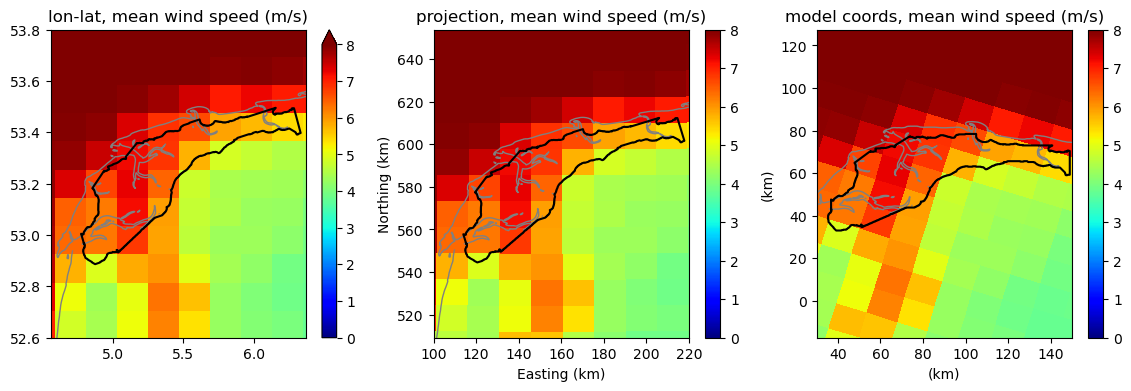

In [142]:
fig,ax= plt.subplots(1,3,figsize=(14,4))

ws=(dsw.u10**2+dsw.v10**2)**.5
ws_avg=ws.mean(dim='time') #avg for 2009

ws_avg.plot.pcolormesh(ax=ax[0],vmin=0,vmax=8,shading='auto',cmap='jet')#wind-energy lon-lat
ax[0].contour(xct,yct,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy in lon-lat from topo file 
ax[0].plot(bdr_dws0_lon,bdr_dws0_lat,'k') #DWS limits in lon-lat
ax[0].axis([4.56,6.37,52.6,53.8]);ax[0].set_xlabel('');ax[0].set_ylabel('')
ax[0].set_title('lon-lat, mean wind speed (m/s)')
#
aa=ax[1].pcolormesh(xcwp,ycwp,ws_avg.values,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].axis('equal');ax[1].axis([100,220,543,620])
ax[1].set_xlabel('Easting (km)');ax[1].set_ylabel('Northing (km)');
ax[1].set_title('projection, mean wind speed (m/s)');
plt.colorbar(aa,ax=ax[1])
#
aa=ax[2].pcolormesh(xcwl,ycwl,ws_avg.values,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
ax[2].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[2].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
ax[2].axis('equal');ax[2].axis([30,150,30,80])
ax[2].set_xlabel('(km)');ax[2].set_ylabel('(km)');
ax[2].set_title('model coords, mean wind speed (m/s)');
plt.colorbar(aa,ax=ax[2])

### Get uw and vw interpolated in particle grid points (with numpy)

CPU times: user 1.41 s, sys: 1.31 s, total: 2.72 s
Wall time: 2.72 s


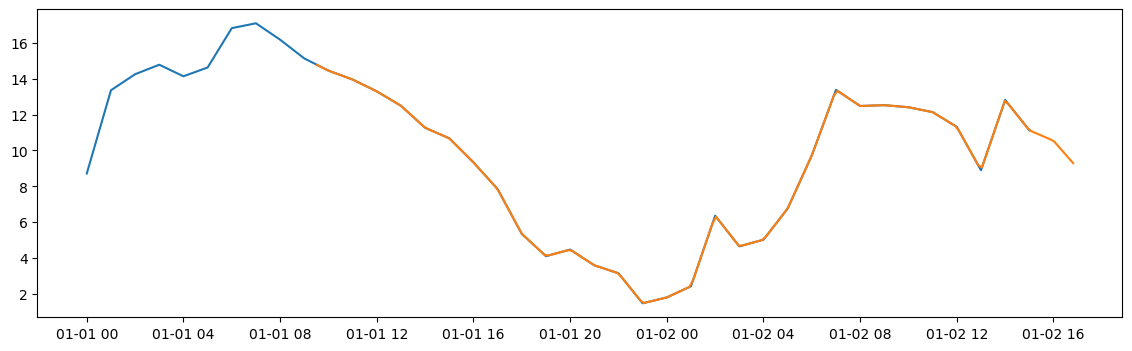

In [27]:
%%time
#interpolation in time with numpy---
#
#convert time to float
t_int0=(t_int-ref_time) / np.timedelta64(1,'s')  #dates to interpolate (consistent with tracks)
tw0=(tw-ref_time) / np.timedelta64(1,'s') #wind
#interp
f = interp1d(tw0, dsw.u10.values, axis=0, kind='linear'); u10_t_int=f(t_int0)
f = interp1d(tw0, dsw.v10.values, axis=0, kind='linear'); v10_t_int=f(t_int0)
#
#check interpolation
plt.figure(figsize=(14,4))
plt.plot(tw[:40],dsw.u10.values[:40,32,19])
plt.plot(t_int[:200],u10_t_int[:200,32,19])
#

#resample to make avg during interval of computation of the net displacement---
#make avg during the interval of displacement (right border of interval open)
#
#using numpy----
nt_interval=int(m2/nt_int) #points in the m2 interval (right border of interval open)
nt_mean=(len(t_int)-1)//nt_interval #final shape after mean in the interval
u10_t_int_mean=np.reshape(u10_t_int[:-1,...],(nt_mean,nt_interval,len(dsw.lat),len(dsw.lon)))                        
u10_t_int_mean=u10_t_int_mean.mean(axis=1)
v10_t_int_mean=np.reshape(v10_t_int[:-1,...],(nt_mean,nt_interval,len(dsw.lat),len(dsw.lon)))                        
v10_t_int_mean=v10_t_int_mean.mean(axis=1)
#
#times are referenced with the date of deployment (the begin of the m2 interval of the displacement)

In [128]:
%%time
#Spatial interpolation of wind data using projected grid, and then to model xc-yc coordinates------

#linear----

#reshape---
#using avg data in m2 interval
ntw,nyw,nxw=u10_t_int_mean.shape
u10l=np.reshape(u10_t_int_mean,(ntw,nyw*nxw))
v10l=np.reshape(v10_t_int_mean,(ntw,nyw*nxw))

#interpolation using model projected coordinates with cubic spline----
#because our wind data is too low resolution in contrast with model grid
#cubic spline interpolation seems more suitable
points=np.array([xcwp.flatten(),ycwp.flatten()]).T
u10l = np.moveaxis(griddata(points, u10l.T, (xctp, yctp), method='linear'),-1,0)
v10l = np.moveaxis(griddata(points, v10l.T, (xctp, yctp), method='linear'),-1,0)
np.sum(np.isnan(u10l)),np.sum(np.isnan(v10l))

CPU times: user 1.68 s, sys: 909 ms, total: 2.59 s
Wall time: 2.6 s


(0, 0)

In [130]:
%%time
#Spatial interpolation of wind data using projected grid, and then to model xc-yc coordinates------

#cubic----

#reshape---
#using avg data in m2 interval
ntw,nyw,nxw=u10_t_int_mean.shape
u10=np.reshape(u10_t_int_mean,(ntw,nyw*nxw))
v10=np.reshape(v10_t_int_mean,(ntw,nyw*nxw))

#interpolation using model projected coordinates with cubic spline----
#because our wind data is too low resolution in contrast with model grid
#cubic spline interpolation seems more suitable
u10 = np.moveaxis(griddata(points, u10.T, (xctp, yctp), method='cubic'),-1,0)
v10 = np.moveaxis(griddata(points, v10.T, (xctp, yctp), method='cubic'),-1,0)
np.sum(np.isnan(u10)),np.sum(np.isnan(v10))

CPU times: user 2min 27s, sys: 2.3 s, total: 2min 30s
Wall time: 2min 30s


(0, 0)

In [132]:
#nearest----

#reshape---
#using avg data in m2 interval
ntw,nyw,nxw=u10_t_int_mean.shape
u10n=np.reshape(u10_t_int_mean,(ntw,nyw*nxw))
v10n=np.reshape(v10_t_int_mean,(ntw,nyw*nxw))

#interpolation using model projected coordinates with cubic spline----
#because our wind data is too low resolution in contrast with model grid
#cubic spline interpolation seems more suitable
points=np.array([xcwp.flatten(),ycwp.flatten()]).T
u10n = np.moveaxis(griddata(points, u10n.T, (xctp, yctp), method='nearest'),-1,0)
v10n = np.moveaxis(griddata(points, v10n.T, (xctp, yctp), method='nearest'),-1,0)
np.sum(np.isnan(u10n)),np.sum(np.isnan(v10n))
#
vel_n=np.mean((u10n**2+v10n**2)**.5,axis=0)

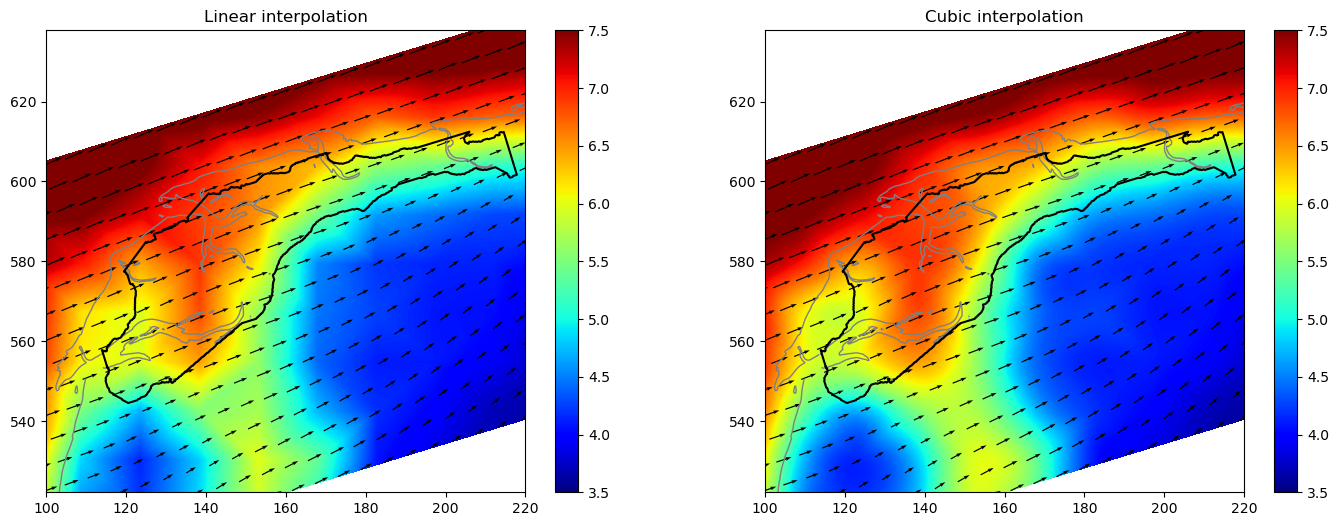

In [100]:
#check above for the avg---
vel_l=np.mean((u10l**2+v10l**2)**.5,axis=0)
u10lm=np.mean(u10l,axis=0);v10lm=np.mean(v10l,axis=0)
vel_c=np.mean((u10**2+v10**2)**.5,axis=0)
u10cm=np.mean(u10,axis=0);v10cm=np.mean(v10,axis=0)
#
fig,ax= plt.subplots(1,2,figsize=(17,6))
iyy=30;ixx=30
units='width';width=0.0025;scale=50
aa=ax[0].pcolormesh(xctp, yctp,vel_l,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0].quiver(xctp[::iyy,::ixx],yctp[::iyy,::ixx],u10lm[::iyy,::ixx],v10lm[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[0].axis('equal');ax[0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0])
ax[0].set_title('Linear interpolation')
aa=ax[1].pcolormesh(xctp, yctp,vel_c,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].quiver(xctp[::iyy,::ixx],yctp[::iyy,::ixx],u10cm[::iyy,::ixx],v10cm[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[1].axis('equal');ax[1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1])
ax[1].set_title('Cubic interpolation');

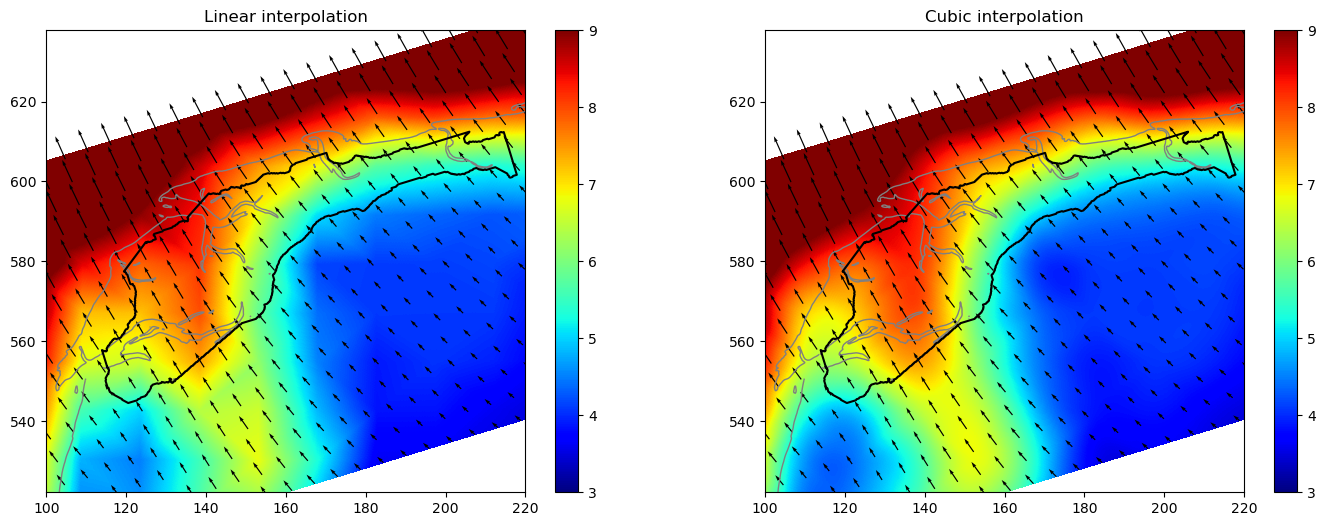

In [59]:
#check above for a particular date---
it=30
vel_l2=(u10l[it,...]**2+v10l[it,...]**2)**.5
vel_c2=(u10[it,...]**2+v10[it,...]**2)**.5
#
fig,ax= plt.subplots(1,2,figsize=(17,6))
iyy=30;ixx=30
units='width';width=0.0025;scale=200
aa=ax[0].pcolormesh(xctp, yctp,vel_l2,vmin=3,vmax=9,shading='auto',cmap='jet') #wind correct orientation
ax[0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0].quiver(xctp[::iyy,::ixx],yctp[::iyy,::ixx],u10l[it,::iyy,::ixx],v10l[it,::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[0].axis('equal');ax[0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0])
ax[0].set_title('Linear interpolation')
aa=ax[1].pcolormesh(xctp, yctp,vel_c2,vmin=3,vmax=9,shading='auto',cmap='jet') #wind correct orientation
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].quiver(xctp[::iyy,::ixx],yctp[::iyy,::ixx],u10[it,::iyy,::ixx],v10[it,::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[1].axis('equal');ax[1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1])
ax[1].set_title('Cubic interpolation');

### Get uw and vw interpolated in particle grid points (with xarray)

CPU times: user 1.14 s, sys: 1.33 s, total: 2.46 s
Wall time: 2.47 s


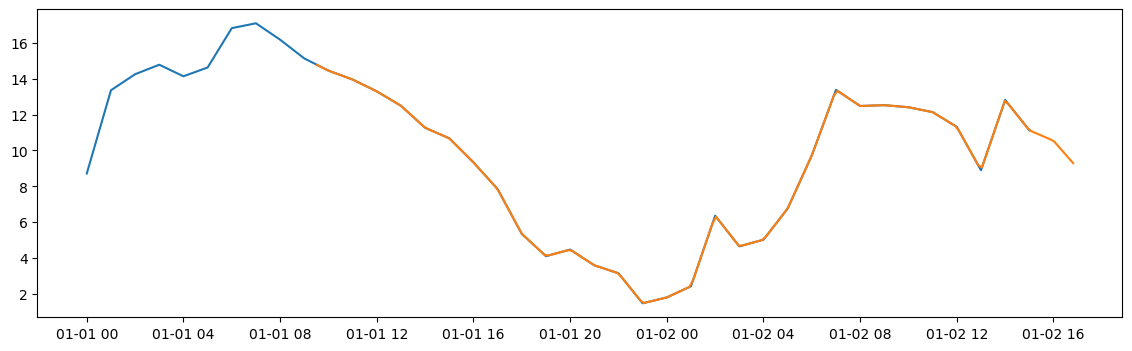

In [60]:
%%time
#interpolation in time with xarray-------
#interp
dsw_int = dsw.interp(time=t_int,method="linear")
#
#check interpolation
plt.figure(figsize=(14,4))
plt.plot(tw[:40],dsw.u10.values[:40,32,19])
plt.plot(t_int[:200],dsw_int.u10[:200,32,19])

In [66]:
#check time dimensions---
nt_interval=int(m2/nt_int) #points in the m2 interval (right border of interval open)
nt_dep=(len(t_int)-1)//nt_interval #=len(t_dep), final shape after mean or std in the m2 interval. "-1" because we also don't consider the right border of the last interval in the avg
#times after avg or std are referenced with the date of deployment (the begin of the m2 interval of the displacement)
nt_interval,nt_dep,len(t_dep),nt_interval*nt_dep,len(dsw_int.time)-1

(79, 705, 705, 55695, 55695)

In [67]:
#https://stackoverflow.com/questions/59504320/how-do-i-subdivide-refine-a-dimension-in-an-xarray-dataset
#steps:
# - assign_coords: create coords time_dep and time_interval 
# - stack: create a coord and index called multi_time which is related to the original temporal size of the data,
#          that now match a 2d-MultiIndex(nt_dep,nt_interval) which is defined using the new time_dep and time_interval coords,
#          and will order the above coords keeping constant time_dep in every time_interval(0:78); which is consistent with how dsw_t_int was created.
# - reset_index().rename: del the the old time coord, and rename time index as multi_time to remove the old time index.
# - unstack(): use the above 2d-MultiIndex to reshape the data original 1d time data into time_dep, time_interval,
#              however, the new dimensions are send by default to the last index, 
# - transpose: to fix above issue for the dimensions of variables, however, can not fix the order that dims are shown after Dimensions:
#
dsw_int=dsw_int.isel(time=range(0,len(dsw_int.time)-1)
        ).assign_coords(time_dep=t_dep,time_interval=range(nt_interval)
        ).stack(multi_time=("time_dep","time_interval")
        ).reset_index("time",drop=True).rename(time="multi_time"
        ).unstack(dim="multi_time").transpose("time_dep","time_interval","lat","lon")
dsw_int #still time in the last on the title of dimensions
#
#not working for fixing above issue
# indexes = dsw_t_int0._indexes
# new_index_order=['time_dep', 'time_interval','lat', 'lon']
# new_index_order = {k: indexes[k] for k in new_index_order}
# dsw_t_int0._indexes=new_index_order
# dsw_t_int0._indexes
#
#instead of above we could also try resample of xarray---
#and then perform avg, std, but not working well
#res=int(nt_int+m2)
#dsout_m2_avg=dsout.resample(time=f'{res}s',closed="right")#.mean(dim='time');
#print(t_dep[:5])
#for i in dsout_m2_avg: print(i)

<xarray.Dataset>
Dimensions:        (lat: 55, lon: 38, time_dep: 705, time_interval: 79)
Coordinates:
  * lon            (lon) float32 2.5 2.72 2.94 3.16 ... 9.98 10.2 10.42 10.64
  * lat            (lat) float32 51.0 51.11 51.22 51.33 ... 56.72 56.83 56.94
  * time_dep       (time_dep) datetime64[ns] 1991-01-01T09:31:36 ... 1991-12-...
  * time_interval  (time_interval) int64 0 1 2 3 4 5 6 ... 72 73 74 75 76 77 78
Data variables:
    u10            (time_dep, time_interval, lat, lon) float64 0.8608 ... 9.826
    v10            (time_dep, time_interval, lat, lon) float64 3.438 ... 11.9
Attributes:
    CDI:          Climate Data Interface version 1.9.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    disclaimer:   uerra2getm.sh (ulf.graewe@io-warnemuende.de)
    CDO:          Climate Data Operators version 1.9.0 (http://mpimet.mpg.de/...

In [68]:
#vectorial avg in the m2 interval---
dsw_int_mean=dsw_int.mean(dim='time_interval')
#dsw_int_std=dsw_int.mean(dim='time_interval')

In [79]:
#spatial interpolation using lon-lat---

#build the input grid (lon-lat of wind file)---
ds_in = xr.Dataset()
ds_in.coords["lat"] = dsw.lat.astype('float32')
ds_in["lat"].attrs['long_name'] = 'latidude'
ds_in.coords["lon"] = dsw.lon.astype('float32')
ds_in["lon"].attrs['long_name'] = 'longitude'
print(ds_in)
print()

#build the output (interpolated) grid (lon-lat of topo file)---
ds_out = xr.Dataset()
ds_out.coords["lat"] = dsto.latc.astype('float32')
ds_out["lat"].attrs['long_name'] = 'latidude'
ds_out.coords["lon"] = dsto.lonc.astype('float32')
ds_out["lon"].attrs['long_name'] = 'longitude'
ds_out=ds_out.drop(["xc","yc"])
print(ds_out)

<xarray.Dataset>
Dimensions:  (lat: 55, lon: 38)
Coordinates:
  * lat      (lat) float32 51.0 51.11 51.22 51.33 ... 56.61 56.72 56.83 56.94
  * lon      (lon) float32 2.5 2.72 2.94 3.16 3.38 ... 9.98 10.2 10.42 10.64
Data variables:
    *empty*

<xarray.Dataset>
Dimensions:  (yc: 486, xc: 820)
Coordinates:
    lat      (yc, xc) float32 52.5 52.5 52.5 52.5 ... 53.76 53.76 53.76 53.76
    lon      (yc, xc) float32 4.469 4.472 4.475 4.478 ... 6.381 6.384 6.387
Dimensions without coordinates: yc, xc
Data variables:
    *empty*


In [80]:
%%time
#only need to run once
regridder_patch = xe.Regridder(ds_in,ds_out,"patch") #special smooth from this package
regridder_bilinear = xe.Regridder(ds_in,ds_out,"bilinear")
regridder_nearest = xe.Regridder(ds_in,ds_out,"nearest_s2d") #classical nearest

CPU times: user 30.1 s, sys: 1.14 s, total: 31.2 s
Wall time: 31.3 s


In [81]:
%%time
# for bilinear: 3.5s with default xarray "K" order, and the same if we use "C" order
# print(dsw_int_mean.u10.values.flags)
# dsw_int_mean_C=dsw_int_mean.astype(dtype="float32",order="C")
# print(dsw_int_mean_C.u10.values.flags)
dsw_int_mean_regrid_bilinear = regridder_bilinear(dsw_int_mean)

/export/lv4/user/jfajardourbina/programs/miniconda3/envs/phd_parcelsv221/lib/python3.8/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/export/lv4/user/jfajardourbina/programs/miniconda3/envs/phd_parcelsv221/lib/python3.8/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


CPU times: user 2.51 s, sys: 873 ms, total: 3.39 s
Wall time: 3.4 s


In [83]:
%%time
#nearest = 2.5s
dsw_int_mean_regrid_nearest = regridder_nearest(dsw_int_mean)

CPU times: user 723 ms, sys: 1.56 s, total: 2.28 s
Wall time: 2.29 s


In [84]:
%%time
#patch = 15s
dsw_int_mean_regrid_patch = regridder_patch(dsw_int_mean)

CPU times: user 14.8 s, sys: 2.1 s, total: 16.9 s
Wall time: 17 s


In [86]:
#verify that the result is the same as regridding each variable one-by-one
#for k in dsw_int_mean.data_vars: print(k, dsw_int_mean_regrid_bilinear[k].equals(regridder_bilinear(dsw_int_mean[k])))

In [135]:
#mean speed for 1990---
ws_original=((dsw.u10**2+dsw.v10**2)**.5).sel(time=slice(None,"1991-12-31")).mean(dim='time')
ws_nearest=((dsw_int_mean_regrid_nearest.u10**2+dsw_int_mean_regrid_nearest.v10**2)**.5).mean(dim="time_dep")
ws_bilinear=((dsw_int_mean_regrid_bilinear.u10**2+dsw_int_mean_regrid_bilinear.v10**2)**.5).mean(dim="time_dep")
ws_patch=((dsw_int_mean_regrid_patch.u10**2+dsw_int_mean_regrid_patch.v10**2)**.5).mean(dim="time_dep")

/tmp/ipykernel_193816/2093955315.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  aa=ax[0,0].pcolormesh(xcwp,ycwp,ws_original,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation


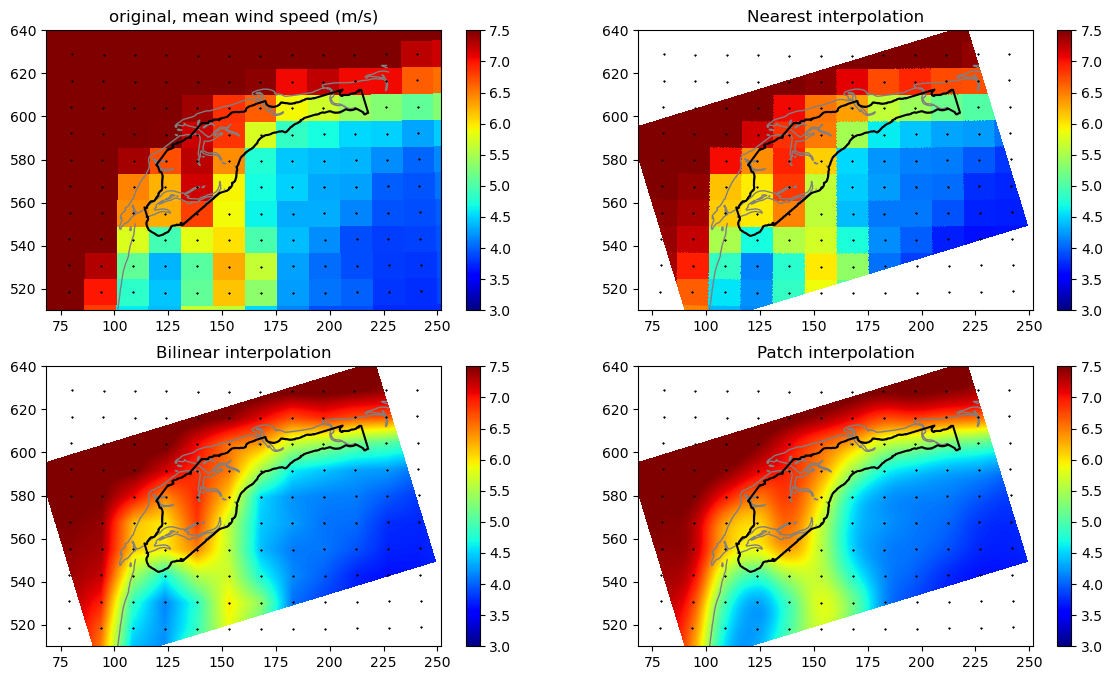

In [138]:
fig,ax= plt.subplots(2,2,figsize=(14,8))

a=xcwp.flatten();b=ycwp.flatten()

aa=ax[0,0].pcolormesh(xcwp,ycwp,ws_original,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0,0].axis('equal');ax[0,0].axis([70,250,510,640])#;ax[0,0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0,0])
ax[0,0].plot(a,b,'*k',ms=1)
ax[0,0].set_title('original, mean wind speed (m/s)')
#
aa=ax[0,1].pcolormesh(xctp,yctp,ws_nearest,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0,1].axis('equal');ax[0,1].axis([70,250,510,640])#;ax[0,1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0,1])
ax[0,1].plot(a,b,'*k',ms=1)
ax[0,1].set_title('Nearest interpolation');
#
aa=ax[1,0].pcolormesh(xctp,yctp,ws_bilinear,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1,0].axis('equal');ax[1,0].axis([70,250,510,640])#;ax[1,0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1,0])
ax[1,0].plot(a,b,'*k',ms=1)
ax[1,0].set_title('Bilinear interpolation');
#
aa=ax[1,1].pcolormesh(xctp,yctp,ws_patch,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1,1].axis('equal');ax[1,1].axis([70,250,510,640])#;ax[1,1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1,1])
ax[1,1].plot(a,b,'*k',ms=1)
ax[1,1].set_title('Patch interpolation');

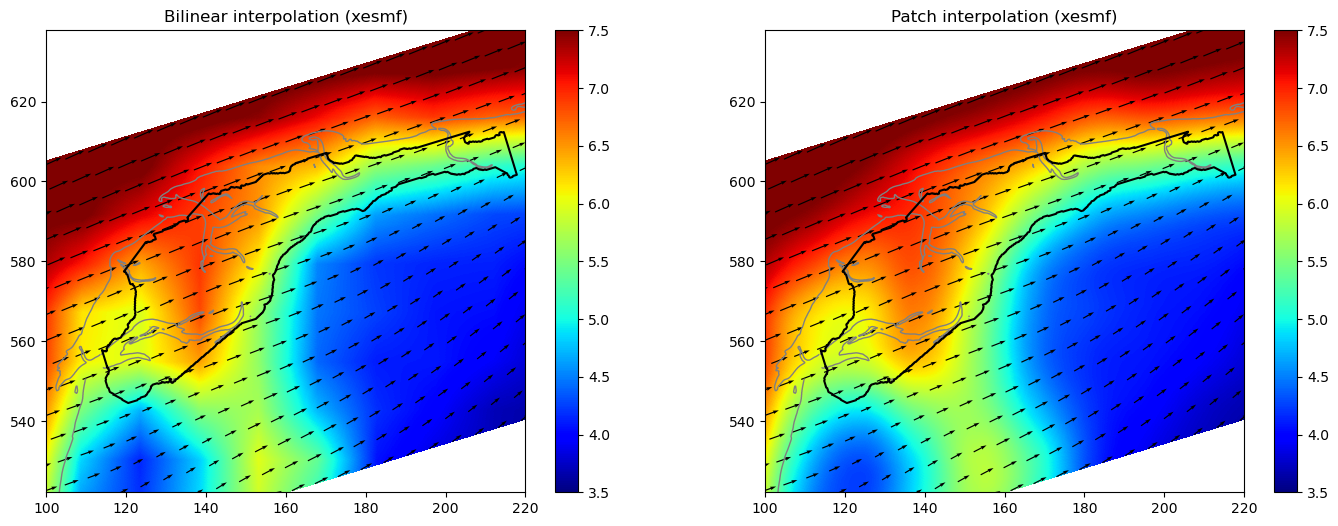

In [150]:
#check above for the avg---
#u10blm=np.mean(dsw_int_mean_regrid_bilinear.u10,axis=0);v10blm=np.mean(dsw_int_mean_regrid_bilinear.v10,axis=0)
#u10pm=np.mean(dsw_int_mean_regrid_patch.u10,axis=0);v10pm=np.mean(dsw_int_mean_regrid_patch.v10,axis=0)
#
fig,ax= plt.subplots(1,2,figsize=(17,6))
iyy=30;ixx=30
units='width';width=0.0025;scale=50
aa=ax[0].pcolormesh(xctp, yctp,ws_bilinear,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0].quiver(xctp[::iyy,::ixx],yctp[::iyy,::ixx],u10blm[::iyy,::ixx],v10blm[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[0].axis('equal');ax[0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0])
ax[0].set_title('Bilinear interpolation (xesmf)')
aa=ax[1].pcolormesh(xctp, yctp,ws_patch,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].quiver(xctp[::iyy,::ixx],yctp[::iyy,::ixx],u10pm[::iyy,::ixx],v10pm[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[1].axis('equal');ax[1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1])
ax[1].set_title('Patch interpolation (xesmf)');

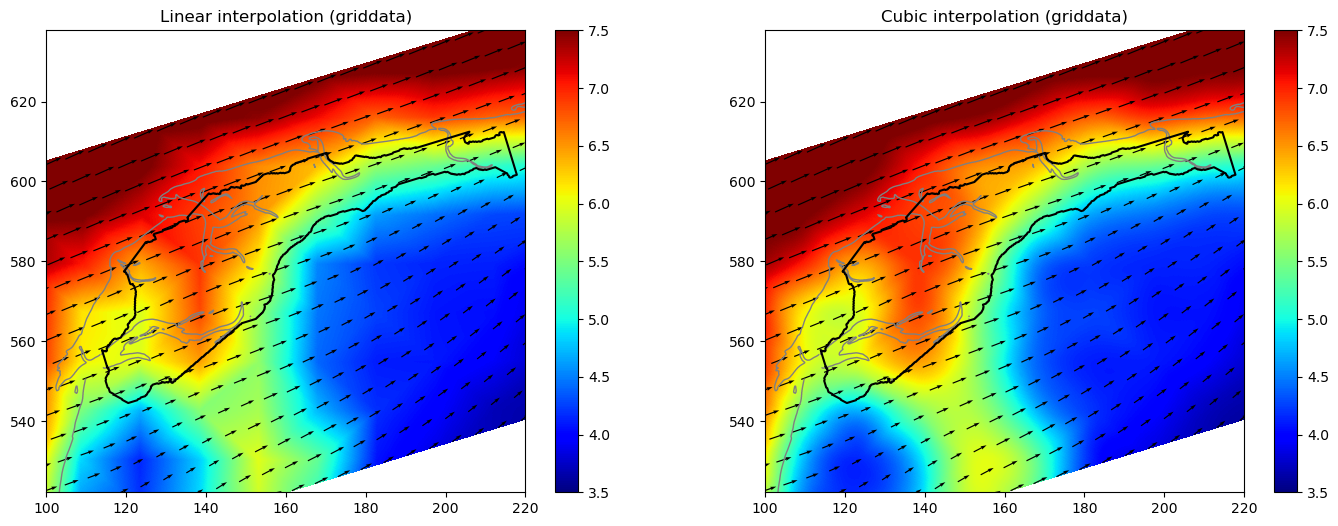

In [151]:
#check again with griddata for the avg---
fig,ax= plt.subplots(1,2,figsize=(17,6))
aa=ax[0].pcolormesh(xctp, yctp,vel_l,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0].quiver(xctp[::iyy,::ixx],yctp[::iyy,::ixx],u10lm[::iyy,::ixx],v10lm[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[0].axis('equal');ax[0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0])
ax[0].set_title('Linear interpolation (griddata)')
aa=ax[1].pcolormesh(xctp, yctp,vel_c,vmin=3.5,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].quiver(xctp[::iyy,::ixx],yctp[::iyy,::ixx],u10cm[::iyy,::ixx],v10cm[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
ax[1].axis('equal');ax[1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1])
ax[1].set_title('Cubic interpolation (griddata)');

In [136]:
%%time
#around 30s (slow in contrast to griddata and xemsmf)
### using only xarray----
#only possible nearest and linear with 2d grid
#
dsw_int_mean_nearest=dsw_int_mean.interp(lon=ds_out.lon,lat=ds_out.lat, method='nearest')
dsw_int_mean_linear=dsw_int_mean.interp(lon=ds_out.lon,lat=ds_out.lat, method='linear')
#
ws_linear=((dsw_int_mean_linear.u10**2+dsw_int_mean_linear.v10**2)**.5).mean(dim="time_dep")
ws_nearest_xr=((dsw_int_mean_nearest.u10**2+dsw_int_mean_nearest.v10**2)**.5).mean(dim="time_dep")

CPU times: user 3.2 s, sys: 5.84 s, total: 9.04 s
Wall time: 9.06 s


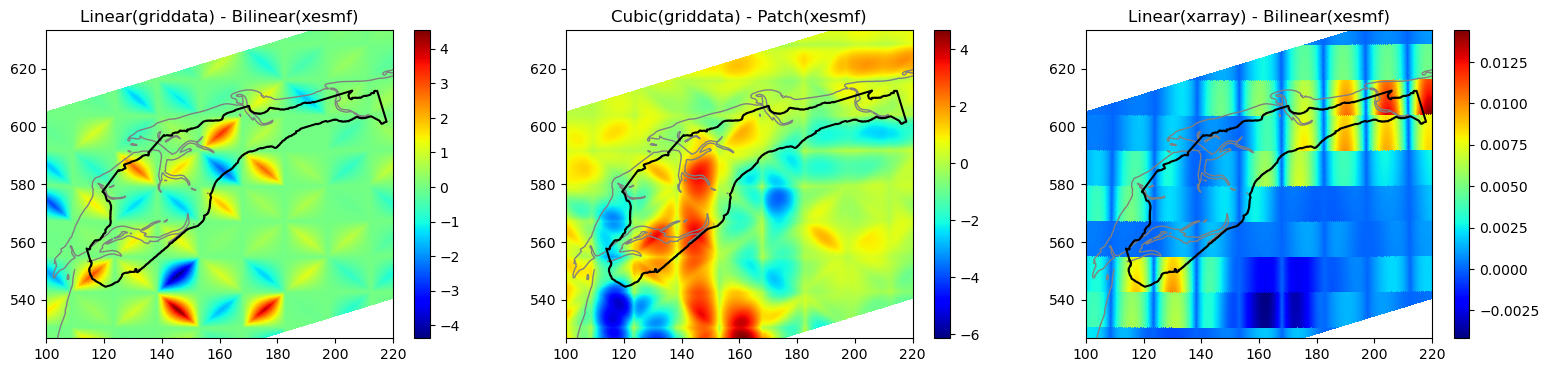

In [125]:
#diff regrid(xesmf) with griddata and linear xarray---
fig,ax= plt.subplots(1,3,figsize=(19,4))
aa=ax[0].pcolormesh(xctp, yctp,(vel_l-ws_bilinear)/ws_bilinear*100,shading='auto',cmap='jet') #wind correct orientation
ax[0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0].axis('equal');ax[0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0])
ax[0].set_title('Linear(griddata) - Bilinear(xesmf)')
#
aa=ax[1].pcolormesh(xctp, yctp,(vel_c-ws_bilinear)/ws_bilinear*100,shading='auto',cmap='jet') #wind correct orientation
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].axis('equal');ax[1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1])
ax[1].set_title('Cubic(griddata) - Patch(xesmf)')
#
aa=ax[2].pcolormesh(xctp, yctp,(ws_linear-ws_bilinear)/ws_bilinear*100,shading='auto',cmap='jet') #wind correct orientation
ax[2].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[2].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[2].axis('equal');ax[2].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[2])
ax[2].set_title('Linear(xarray) - Bilinear(xesmf)');

/tmp/ipykernel_193816/1249324199.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  aa=ax[0,0].pcolormesh(xcwp,ycwp,ws_original,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation


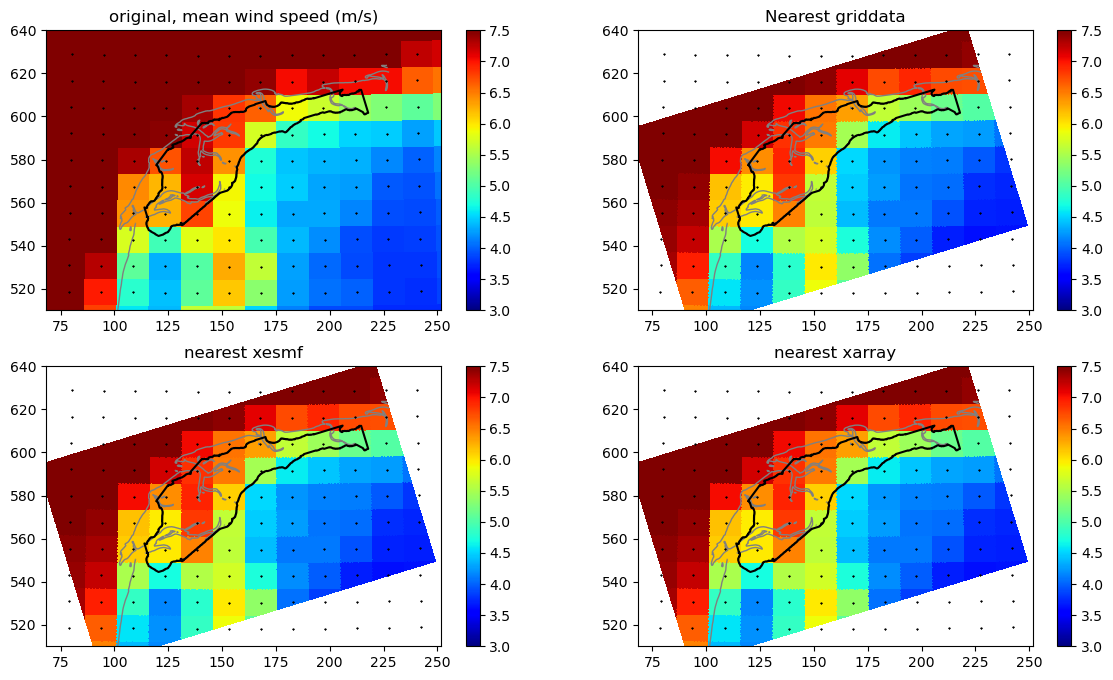

In [ ]:
fig,ax= plt.subplots(2,2,figsize=(14,8))

a=xcwp.flatten();b=ycwp.flatten()

aa=ax[0,0].pcolormesh(xcwp,ycwp,ws_original,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0,0].axis('equal');ax[0,0].axis([70,250,510,640])#;ax[0,0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0,0])
ax[0,0].plot(a,b,'*k',ms=1)
ax[0,0].set_title('original, mean wind speed (m/s)')
#
aa=ax[0,1].pcolormesh(xctp,yctp,vel_n,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0,1].axis('equal');ax[0,1].axis([70,250,510,640])#;ax[0,1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0,1])
ax[0,1].plot(a,b,'*k',ms=1)
ax[0,1].set_title('Nearest griddata');
#
#aa=ax[1,0].contourf(xctp,yctp,values_int_li,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[1,0].pcolormesh(xctp,yctp,ws_nearest,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1,0].axis('equal');ax[1,0].axis([70,250,510,640])#;ax[1,0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1,0])
ax[1,0].plot(a,b,'*k',ms=1)
ax[1,0].set_title('nearest xesmf');
#
#aa=ax[1,1].contourf(xctp,yctp,values_int,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[1,1].pcolormesh(xctp,yctp,ws_nearest_xr,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1,1].axis('equal');ax[1,1].axis([70,250,510,640])#;ax[1,1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1,1])
ax[1,1].plot(a,b,'*k',ms=1)
ax[1,1].set_title('nearest xarray');

In [ ]:
#So:
#- it seems that the best results are for linear and patch from xesmf
#- but the difference inside the DWS is just around 3%
#- using vectorial avg during m2 and then compute wind speed underestimate the scalar definition

In [201]:
# #spatial interpolation using projected coords (not working)---
# #seems xesmf only works with lon-lat data

# #build the input grid (projected of wind file)---
# ds_inp = xr.Dataset()
# ds_inp.coords["lon"] = (("ycw","xcw"),xcwp.astype('float32'))  #xr_xctp.astype('float32')
# ds_inp["lon"].attrs['long_name'] = 'longitude'
# ds_inp.coords["lat"] = (("ycw","xcw"),ycwp.astype('float32')) 
# ds_inp["lat"].attrs['long_name'] = 'latidude'
# print(ds_inp)
# print()
# #build the output (interpolated) grid (projected of topo file)---
# ds_outp = xr.Dataset()
# ds_outp.coords["lon"] = (("yc","xc"),xctp.astype('float32'))  #xr_xctp.astype('float32')
# ds_outp["lon"].attrs['long_name'] = 'longitude'
# ds_outp.coords["lat"] = (("yc","xc"),yctp.astype('float32')) 
# ds_outp["lat"].attrs['long_name'] = 'latidude'
# print(ds_outp)

# #only need to run once
# regridder_patchp = xe.Regridder(ds_inp,ds_outp,"patch") #special smooth from this package
# regridder_bilinearp = xe.Regridder(ds_inp,ds_outp,"bilinear")
# regridder_nearestp = xe.Regridder(ds_inp,ds_outp,"nearest_s2d") #classical nearest

# dsw_int_mean_regrid_bilinearp = regridder_bilinearp(dsw_int_mean)
# dsw_int_mean_regrid_patchp = regridder_patchp(dsw_int_mean)
# dsw_int_mean_regrid_nearestp = regridder_nearestp(dsw_int_mean)

# #mean speed for 1990---
# ws_nearestp=((dsw_int_mean_regrid_nearestp.u10**2+dsw_int_mean_regrid_nearestp.v10**2)**.5).mean(dim="time_dep")
# ws_bilinearp=((dsw_int_mean_regrid_bilinearp.u10**2+dsw_int_mean_regrid_bilinearp.v10**2)**.5).mean(dim="time_dep")
# ws_patchp=((dsw_int_mean_regrid_patchp.u10**2+dsw_int_mean_regrid_patchp.v10**2)**.5).mean(dim="time_dep")

/tmp/ipykernel_193816/1398194707.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  aa=ax[0,0].pcolormesh(xcwp,ycwp,ws_original,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation


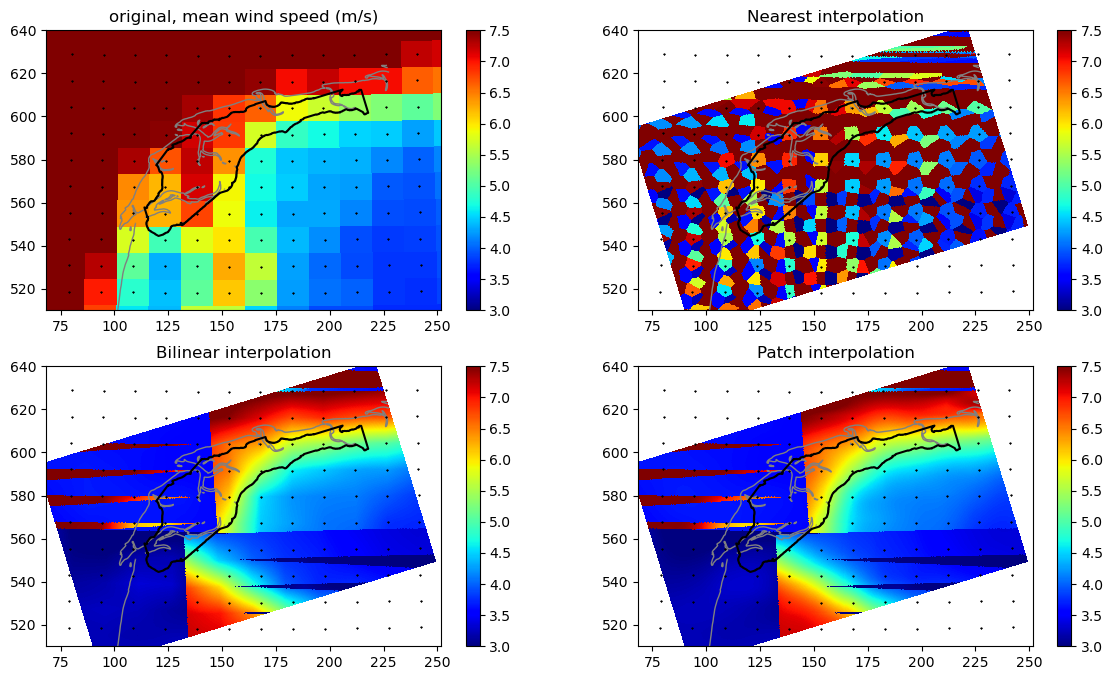

In [200]:
fig,ax= plt.subplots(2,2,figsize=(14,8))

a=xcwp.flatten();b=ycwp.flatten()

aa=ax[0,0].pcolormesh(xcwp,ycwp,ws_original,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0,0].axis('equal');ax[0,0].axis([70,250,510,640])#;ax[0,0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0,0])
ax[0,0].plot(a,b,'*k',ms=1)
ax[0,0].set_title('original, mean wind speed (m/s)')
#
aa=ax[0,1].pcolormesh(xctp,yctp,ws_nearestp,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[0,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0,1].axis('equal');ax[0,1].axis([70,250,510,640])#;ax[0,1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[0,1])
ax[0,1].plot(a,b,'*k',ms=1)
ax[0,1].set_title('Nearest interpolation');
#
aa=ax[1,0].pcolormesh(xctp,yctp,ws_bilinearp,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1,0].axis('equal');ax[1,0].axis([70,250,510,640])#;ax[1,0].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1,0])
ax[1,0].plot(a,b,'*k',ms=1)
ax[1,0].set_title('Bilinear interpolation');
#
aa=ax[1,1].pcolormesh(xctp,yctp,ws_patchp,vmin=3,vmax=7.5,shading='auto',cmap='jet') #wind correct orientation
ax[1,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1,1].axis('equal');ax[1,1].axis([70,250,510,640])#;ax[1,1].axis([100,220,540,620])
plt.colorbar(aa,ax=ax[1,1])
ax[1,1].plot(a,b,'*k',ms=1)
ax[1,1].set_title('Patch interpolation');